# Genetic Algorithm for Strong Lottery Tickets — Moons Dataset

Evolves binary masks over a **fixed, randomly-initialised MLP** to find
sub-networks that classify the scikit-learn *moons* dataset **without any
weight training** (Strong Lottery Ticket).

| Setting | Value |
|---------|-------|
| Dataset | `make_moons` (1 000 samples, noise = 0.3) |
| Model | MLP 2 → 32 → 32 → 32 → 2 (~1 274 params) |
| Init | Uniform [-1, 1] |
| Pop / Gens | 100 / 100 – 200 |
| Fitness | Accuracy (binary task) |
| Post-prune | configurable |

**GA hyper-parameters** (paper defaults):
rec_rate = 0.3, mut_rate = 0.1, mig_rate = 0.1,
par_rate = 0.3, stagnation = 50 generations.

## 1 — Imports

In [1]:
import sys, os, json, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Project root
ROOT = Path(os.getcwd()).parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.util import set_seed, get_prunable_layers, apply_masks_to_model
from src.ga import GAConfig, GeneticAlgorithmPruner, bitvector_to_masks, _evaluate_mask_on_data

print(f"PyTorch {torch.__version__}")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

PyTorch 2.8.0+cu126
Device: cuda


## 2 — Dataset (moons)

Train: 800 samples  |  Test: 200 samples


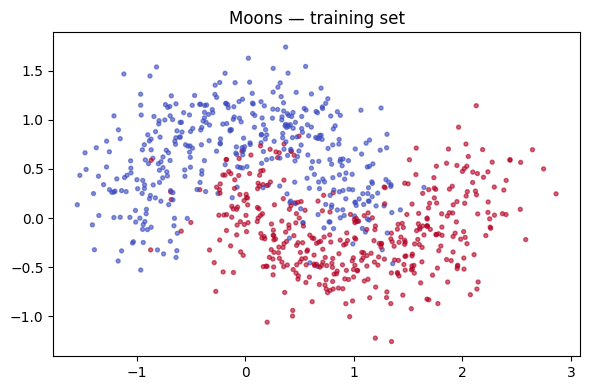

In [2]:
SEED = 42
set_seed(SEED)

# Generate moons dataset: 1000 samples, noise=0.3 (as per paper)
X, y = make_moons(n_samples=1000, noise=0.3, random_state=SEED)

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Convert to PyTorch tensors
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).long()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).long()

BATCH_SIZE = 128
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=BATCH_SIZE)

print(f"Train: {len(X_train)} samples  |  Test: {len(X_test)} samples")

# Quick scatter plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', s=8, alpha=0.6)
ax.set_title("Moons — training set")
plt.tight_layout()
plt.show()

## 3 — Model definition

Feedforward MLP: **2 → 32 → 32 → 32 → 2** with ReLU activations.
Weights initialised uniformly from **[-1, 1]** (paper default).
Biases initialised but **not pruned** (only `nn.Linear` weights are prunable).

In [3]:
class MoonsMLP(nn.Module):
    """Small MLP for the moons binary classification task."""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


def make_model(seed=42):
    """Create MLP with uniform [-1, 1] weight init."""
    set_seed(seed)
    model = MoonsMLP().to(DEVICE)
    with torch.no_grad():
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, -1.0, 1.0)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, -1.0, 1.0)
    return model


model = make_model(SEED)

# Count parameters
prunable = get_prunable_layers(model)
total_prunable = sum(w.size for w in prunable.values())
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters   : {total_params:,}")
print(f"Prunable (weights) : {total_prunable:,}")
print(f"Layers: {list(prunable.keys())}")

Total parameters   : 2,274
Prunable (weights) : 2,176
Layers: ['fc1', 'fc2', 'fc3', 'fc4']


## 4 — GA configuration & run

In [4]:
ga_config = GAConfig(
    population_size=100,
    rec_rate=0.3,
    mut_rate=0.1,
    mig_rate=0.1,
    par_rate=0.3,
    min_generations=100,
    max_generations=200,
    stagnation_threshold=50,
    use_adaptive_ab=False,       # plain GA variant (baseline)
    use_loss_fitness=False,      # use accuracy for binary task
    max_eval_batches=None,       # evaluate on full training set
    post_prune=False,            # disable post-pruning for initial run
)

pruner = GeneticAlgorithmPruner(
    model=model,
    train_loader=train_loader,
    device=DEVICE,
    config=ga_config,
    verbose=True,
)

best_masks, ga_stats = pruner.run()


Genetic Algorithm – Lottery Ticket Search
  genome length  : 2,176
  population     : 100
  generations    : 100–200
  rec / mut / mig: 0.3 / 0.1 / 0.1
  fitness        : accuracy
  adaptive AB    : False
  post-pruning   : False



GA generation:  92%|▉| 185/200 [00:49<00:04,  3.74it/s, cache=38%, perf=92.1250,


Stagnation detected at generation 185. Stopping.

GA completed in 50.9s  (50.9s evolution)
  best performance : 92.1250
  best sparsity    : 0.5023
  cache entries    : 5918



## 5 — Evaluate on test set

In [5]:
# Evaluate the best mask on the TEST set (unseen data)
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = _evaluate_mask_on_data(
    model, best_masks, test_loader, criterion, DEVICE
)
train_loss, train_acc = _evaluate_mask_on_data(
    model, best_masks, train_loader, criterion, DEVICE
)

sparsity = ga_stats['best_sparsity']

print(f"{'='*50}")
print(f"  GA Result (no weight training)")
print(f"{'='*50}")
print(f"  Train accuracy : {train_acc:.2f}%")
print(f"  Test accuracy  : {test_acc:.2f}%")
print(f"  Sparsity       : {sparsity:.2%}")
print(f"  Generations    : {ga_stats['total_generations']}")
print(f"  Time           : {ga_stats['total_time_seconds']:.1f}s")
print(f"  Cache entries  : {ga_stats['cache_entries']}")
print(f"{'='*50}")

  GA Result (no weight training)
  Train accuracy : 92.12%
  Test accuracy  : 93.00%
  Sparsity       : 50.23%
  Generations    : 186
  Time           : 50.9s
  Cache entries  : 5918


## 6 — Visualise GA evolution

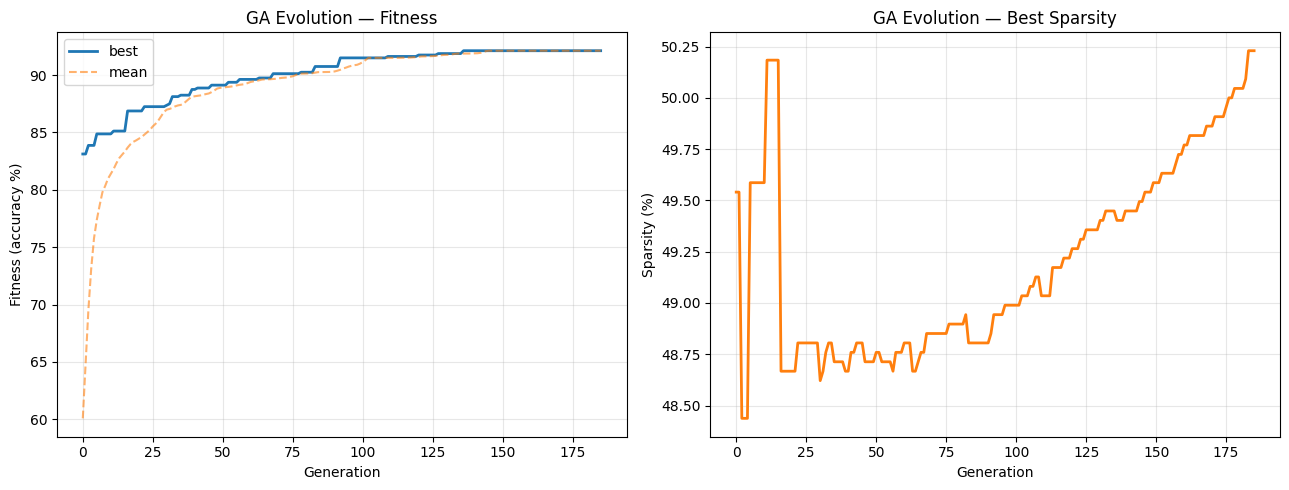

In [6]:
gens_hist = ga_stats['generations']
gens      = [g['generation'] for g in gens_hist]
best_perf = [g['best_perf'] for g in gens_hist]
mean_perf = [g['mean_perf'] for g in gens_hist]
best_sp   = [g['best_sparsity'] for g in gens_hist]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Fitness over generations
ax1.plot(gens, best_perf, label='best', linewidth=2)
ax1.plot(gens, mean_perf, '--', label='mean', alpha=0.6)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness (accuracy %)')
ax1.set_title('GA Evolution — Fitness')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sparsity over generations
ax2.plot(gens, [s * 100 for s in best_sp], color='tab:orange', linewidth=2)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Sparsity (%)')
ax2.set_title('GA Evolution — Best Sparsity')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7 — Decision boundary

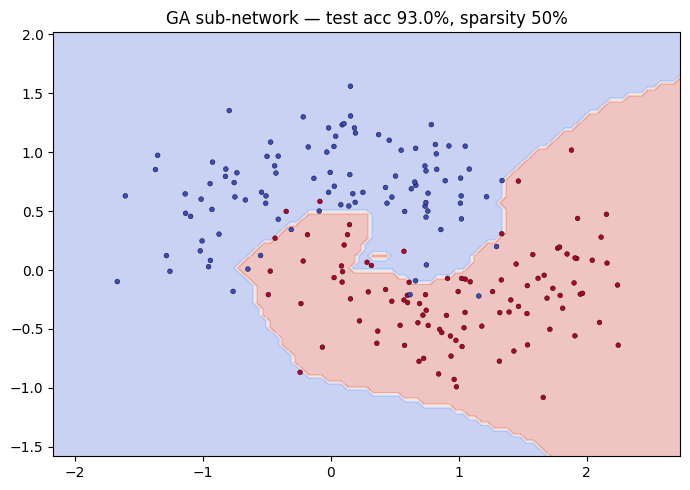

In [7]:
# Plot decision boundary of the discovered sub-network
def plot_decision_boundary(model, masks, X, y, title="Decision Boundary"):
    apply_masks_to_model(model, masks)
    model.eval()

    h = 0.05
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(DEVICE)

    with torch.no_grad():
        preds = model(grid).argmax(dim=1).cpu().numpy()
    Z = preds.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=12, edgecolors='k', linewidths=0.3)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Reload clean model weights, then visualise
model = make_model(SEED)
plot_decision_boundary(model, best_masks, X_test, y_test,
                       title=f"GA sub-network — test acc {test_acc:.1f}%, sparsity {sparsity:.0%}")

## 8 — Post-evolutionary pruning comparison

Re-run with `post_prune=True` to see how much extra sparsity the sequential
bit-zeroing step can add without hurting accuracy.

In [8]:
# Re-run GA with post-evolutionary pruning enabled
model_pp = make_model(SEED)

ga_config_pp = GAConfig(
    population_size=100,
    rec_rate=0.3,
    mut_rate=0.1,
    mig_rate=0.1,
    par_rate=0.3,
    min_generations=100,
    max_generations=200,
    stagnation_threshold=50,
    use_adaptive_ab=False,
    use_loss_fitness=False,
    max_eval_batches=None,
    post_prune=True,              # <-- enable post-pruning
)

pruner_pp = GeneticAlgorithmPruner(
    model=model_pp,
    train_loader=train_loader,
    device=DEVICE,
    config=ga_config_pp,
    verbose=True,
)

best_masks_pp, ga_stats_pp = pruner_pp.run()

# Evaluate on test set
test_loss_pp, test_acc_pp = _evaluate_mask_on_data(
    model_pp, best_masks_pp, test_loader, criterion, DEVICE
)
sparsity_pp = ga_stats_pp['best_sparsity']

# Compare
print(f"\n{'='*55}")
print(f"  {'Metric':<20} {'No post-prune':>15} {'Post-prune':>15}")
print(f"  {'-'*50}")
print(f"  {'Test accuracy':<20} {test_acc:>14.2f}% {test_acc_pp:>14.2f}%")
print(f"  {'Sparsity':<20} {sparsity:>14.2%} {sparsity_pp:>14.2%}")
print(f"  {'Generations':<20} {ga_stats['total_generations']:>15d} {ga_stats_pp['total_generations']:>15d}")
print(f"  {'Time (s)':<20} {ga_stats['total_time_seconds']:>15.1f} {ga_stats_pp['total_time_seconds']:>15.1f}")
print(f"{'='*55}")


Genetic Algorithm – Lottery Ticket Search
  genome length  : 2,176
  population     : 100
  generations    : 100–200
  rec / mut / mig: 0.3 / 0.1 / 0.1
  fitness        : accuracy
  adaptive AB    : False
  post-pruning   : True



GA generation:  92%|▉| 185/200 [00:49<00:04,  3.72it/s, cache=38%, perf=92.1250,



Stagnation detected at generation 185. Stopping.

Post-evolutionary pruning …


Post-pruning: 100%|████████████████████████| 1083/1083 [00:09<00:00, 120.10it/s]

  Post-pruning removed 698 additional weights → sparsity 0.8231

GA completed in 59.6s  (50.5s evolution)
  best performance : 92.5000
  best sparsity    : 0.8231
  cache entries    : 5918


  Metric                 No post-prune      Post-prune
  --------------------------------------------------
  Test accuracy                 93.00%          95.00%
  Sparsity                     50.23%         82.31%
  Generations                      186             186
  Time (s)                        50.9            59.6
